In [1]:
# Import necessary libraries

import os
import torch
import h5py
import gc
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from torch.utils.data import Dataset

def clear_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def get_device():
    """Get the best available device with optimized settings"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.set_per_process_memory_fraction(0.8)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.set_default_dtype(torch.float32)
        clear_memory()
    else:
        device = torch.device('cpu')
    torch.set_default_device(device)
    return device

clear_memory()

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Hyperparameters and configurations

class CFG:
    batch_size = 32
    img_size = (128, 128)
    mean = [0.45674816, 0.43342975, 0.38905367]     # Calculated during fine-tuning
    std = [0.27190068, 0.26165867, 0.270301]        # Calculated during fine-tuning
    k = 5

In [3]:
# Creating the CNN model

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.encoder = nn.Sequential(
      # Input: 128 x 128 x 3
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 64 x 64 x 32

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 32 x 32 x 64

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 16 x 16 x 128

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
      nn.Flatten(),
      # Output: 16*16*256 = 65536 x 1
      nn.Linear(65536, 256),
      # Output: 512 x 1
      nn.ReLU(),
      nn.Linear(256, 256),
      # Output: 256 x 1
      nn.ReLU(),
      nn.Linear(256, 100)
      # Output: 100 x 1
    )
    
    self.features = nn.Sequential(
      nn.Flatten(),
      nn.Linear(65536, 768),
    )
    # Apply Xavier Initialization
    self.init_xavier()

  def init_xavier(self):
    for layer in self.modules():
      if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)

  def forward(self, x):
    x = self.encoder(x)
    feat = self.features(x)
    x = self.dense_layers(x)
    return x, feat

In [4]:
# Custom Image Dataset Class

class ImgFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, filename) 
            for filename in os.listdir(root) 
            if filename.endswith('.png')
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        filename = os.path.basename(img_path)
        if self.transform:
            image = self.transform(image)
        return image, filename

In [5]:
# Load models

device = get_device()

cnn_model = CNN().to(device)
cnn_model.load_state_dict(torch.load("FineTuneCNN.pth"))
cnn_model.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.load_state_dict(torch.load("FineTuneBERT.pth"))
bert_model.eval()

images_dir = "data/images"
transform = transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
    transforms.Normalize(CFG.mean, CFG.std),
])

dataset = ImgFolder(root=images_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

C:\Users\shayo\AppData\Local\Temp\ipykernel_34776\3034759775.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load("FineTuneCNN.pth"))
C:\

In [6]:
# Precompute and Save Image Embeddings

embeddings_file = "image_embeddings.h5"
if not os.path.exists(embeddings_file):
    print("Precomputing image embeddings...")
    with h5py.File(embeddings_file, "w") as hdf:
        for images, filenames in tqdm(dataloader, desc="Processing Image Embeddings"):
            with torch.no_grad():
                _, embeddings = cnn_model(images.to(device))
            for filename, embedding in zip(filenames, embeddings):
                hdf.create_dataset(filename, data=embedding.cpu().numpy())
    print(f"Image embeddings saved to {embeddings_file}")
else:
    print(f"Embeddings file {embeddings_file} already exists.")

Precomputing image embeddings...


Processing Image Embeddings: 100%|██████████| 287/287 [03:27<00:00,  1.38it/s]

Image embeddings saved to image_embeddings.h5


In [10]:
# Process User Query and Retrieve Top-K Images

def process_query(query, bert_model, tokenizer, embeddings_file, k=3):
    with torch.no_grad():
        tokens = tokenizer(query, return_tensors="pt", padding=True, truncation=True).to(device)
        query_embedding = bert_model(**tokens).last_hidden_state.mean(dim=1).squeeze().cpu()

    with h5py.File(embeddings_file, "r") as hdf:
        similarities = []
        for filename in hdf.keys():
            img_embedding = torch.tensor(hdf[filename][:]).cpu()
            similarity = 1 - cosine(query_embedding.numpy(), img_embedding.numpy())
            similarities.append((filename, similarity))

    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    return top_k

Top K Images: [('8419.png', 0.3843222952342127), ('6824.png', 0.3827601876734611), ('5746.png', 0.36649530094777993), ('3395.png', 0.3637100015858923), ('3169.png', 0.35891722173665697), ('3619.png', 0.3577359473852866), ('4863.png', 0.3554005350901617)]


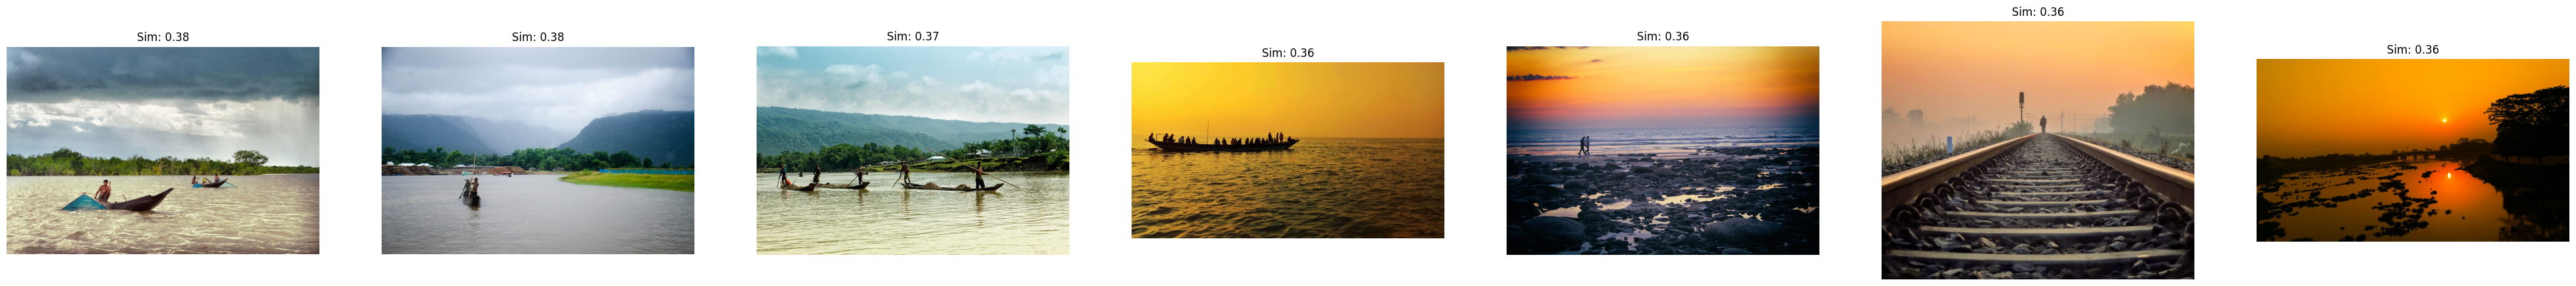

In [17]:
# Step 3: Display Top-K Images

def display_images(top_k_images, images_dir):
    plt.figure(figsize=(50, 50))
    for i, (filename, similarity) in enumerate(top_k_images):
        img_path = os.path.join(images_dir, filename)
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, len(top_k_images), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Sim: {similarity:.2f}")
    plt.show()

# User query
query = "A beautiful sunset over the mountains"
top_k_images = process_query(query, bert_model, tokenizer, embeddings_file, k=CFG.k)
display_images(top_k_images, images_dir)